In [ ]:
# ============================================================
# JUPYTER NOTEBOOK VERSION OF "Optimised Sampling Design"
# ============================================================

import os
import tempfile
import zipfile
from pathlib import Path

import geopandas as gpd
import rasterio
from rasterio.mask import mask

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pyproj import CRS

# your project modules
import utils
import stratify
from pyproj import Transformer

# ---------------------------
# Paths & configuration
# ---------------------------
BASE_DIR   = Path.cwd()  # or Path(__file__).resolve().parent if you run as a script
DATA_DIR   = BASE_DIR / "data"
OUTPUT_DIR = BASE_DIR / "output"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

DST_CRS = CRS.from_epsg(32755)

# === USER INPUTS (edit these) ===
VECTOR_PATH = Path("/home/marliana/shared_folder/CarbonApp/data/vector/John_Bruce_Pye_Farm-boundaries.zip")  # zip shp / geojson / kml / kmz
# VECTOR_PATH = Path("/home/marliana/shared_folder/CarbonApp/data/vector/TalaveraBoundary.zip")
# VECTOR_PATH = Path("/home/marliana/shared_folder/CarbonApp/data/vector/Llara_bounds.zip")
# Example:
# VECTOR_PATH = BASE_DIR / "example_inputs" / "farm_boundary.zip"

crop_to_geom = True
all_touched  = True

meanSOC_in = DATA_DIR / "SOC_AU/SOC_0_100_stock_tonclipped_30m.tif"
varSOC_in  = DATA_DIR / "SOC_AU/SOC_0_100_variance_tonclipped_30m.tif"

meanSOC_out = OUTPUT_DIR / "clipped_SOC_mean.tif"
varSOC_out  = OUTPUT_DIR / "clipped_SOC_var.tif"

buffer_m = 15
minDistance = 25
edge_buffer = 15
nh_min = 3
H_max = 7
aimed_Svar_factor = 0.02  # aimed_Svar = var * this


In [ ]:

 
transformer = Transformer.from_crs(
    "EPSG:32755",
    "EPSG:4326",
    always_xy=True
)

# ---------------------------
# Helpers
# ---------------------------
def smart_format(x, fixed_decimals=4, sci_threshold=1e-3):
    if x == 0:
        return "0"
    if abs(x) < sci_threshold:
        return f"{x:.2e}"
    return f"{x:.{fixed_decimals}f}"


def read_vector_file(path: Path) -> gpd.GeoDataFrame:
    """
    Reads:
      - ZIP Shapefile
      - GeoJSON/JSON
      - KML
      - KMZ
    Returns GeoDataFrame.
    """
    path = Path(path)
    name = path.name.lower()

    if not path.exists():
        raise FileNotFoundError(f"Vector file not found: {path}")

    # ---- Shapefile ZIP ----
    if name.endswith(".zip"):
        with tempfile.TemporaryDirectory() as tmpdir:
            tmpdir = Path(tmpdir)

            with zipfile.ZipFile(path, "r") as z:
                z.extractall(tmpdir)

            shp_files = list(tmpdir.glob("*.shp")) + list(tmpdir.rglob("*.shp"))
            if not shp_files:
                raise ValueError("ZIP does not contain a .shp file.")
            return gpd.read_file(shp_files[0])

    # ---- KMZ (zip containing KML) ----
    if name.endswith(".kmz"):
        with tempfile.TemporaryDirectory() as tmpdir:
            tmpdir = Path(tmpdir)

            with zipfile.ZipFile(path, "r") as z:
                kml_candidates = [p for p in z.namelist() if p.lower().endswith(".kml")]
                if not kml_candidates:
                    raise ValueError("KMZ does not contain a .kml file.")
                kml_name = kml_candidates[0]
                z.extract(kml_name, tmpdir)
                kml_path = tmpdir / kml_name

            try:
                return gpd.read_file(kml_path, driver="KML")
            except TypeError:
                return gpd.read_file(kml_path)

    # ---- KML ----
    if name.endswith(".kml"):
        try:
            return gpd.read_file(path, driver="KML")
        except TypeError:
            return gpd.read_file(path)

    # ---- GeoJSON / JSON ----
    if name.endswith(".geojson") or name.endswith(".json"):
        return gpd.read_file(path)

    raise ValueError(f"Unsupported file type: {path.suffix}")


def calculate_area_ha(gdf: gpd.GeoDataFrame, dst_crs=DST_CRS) -> float:
    if gdf.empty:
        raise ValueError("Vector file has no features.")
    if gdf.crs is None:
        raise ValueError("Vector CRS missing (.prj missing).")

    if gdf.crs != dst_crs:
        gdf = gdf.to_crs(dst_crs)

    geom = gdf.geometry.unary_union
    area_m2 = geom.area
    return area_m2 / 10_000.0


def clip_raster(
    path_raster_in: str | Path,
    path_raster_out: str | Path,
    gdf: gpd.GeoDataFrame,
    crop: bool,
    all_touched: bool,
    buffer_m: float = 0.0,
) -> None:
    if gdf.empty:
        raise ValueError("Vector file has no features.")
    if gdf.crs is None:
        raise ValueError("Vector CRS missing.")

    path_raster_in = str(path_raster_in)
    path_raster_out = str(path_raster_out)

    with rasterio.open(path_raster_in) as src:
        if src.crs is None:
            raise ValueError("Raster CRS missing.")

        # reproject vector to raster CRS (buffer in raster units)
        gdf2 = gdf
        if gdf2.crs != src.crs:
            gdf2 = gdf2.to_crs(src.crs)

        geom = gdf2.geometry.unary_union
        if buffer_m and buffer_m != 0:
            geom = geom.buffer(buffer_m)

        out_image, out_transform = mask(
            src,
            [geom],
            crop=crop,
            all_touched=all_touched,
            nodata=src.nodata,
            filled=True,
        )

        out_meta = src.meta.copy()
        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform,
        })

        # ensure nodata exists
        if out_meta.get("nodata", None) is None:
            if "float" in str(out_meta["dtype"]).lower():
                out_meta["nodata"] = -9999.0
            else:
                out_meta["nodata"] = 0

        with rasterio.open(path_raster_out, "w", **out_meta) as dst:
            dst.write(out_image)




Area of Farm (ha): 167.13
Clipped rasters saved:
 - /home/marliana/shared_folder/CarbonApp/output/clipped_SOC_mean.tif
 - /home/marliana/shared_folder/CarbonApp/output/clipped_SOC_var.tif
Mean estimated Carbon Stock (0–100 cm): 83.28 ton
Mean variance of estimated Carbon Stock: 763.10 ton²


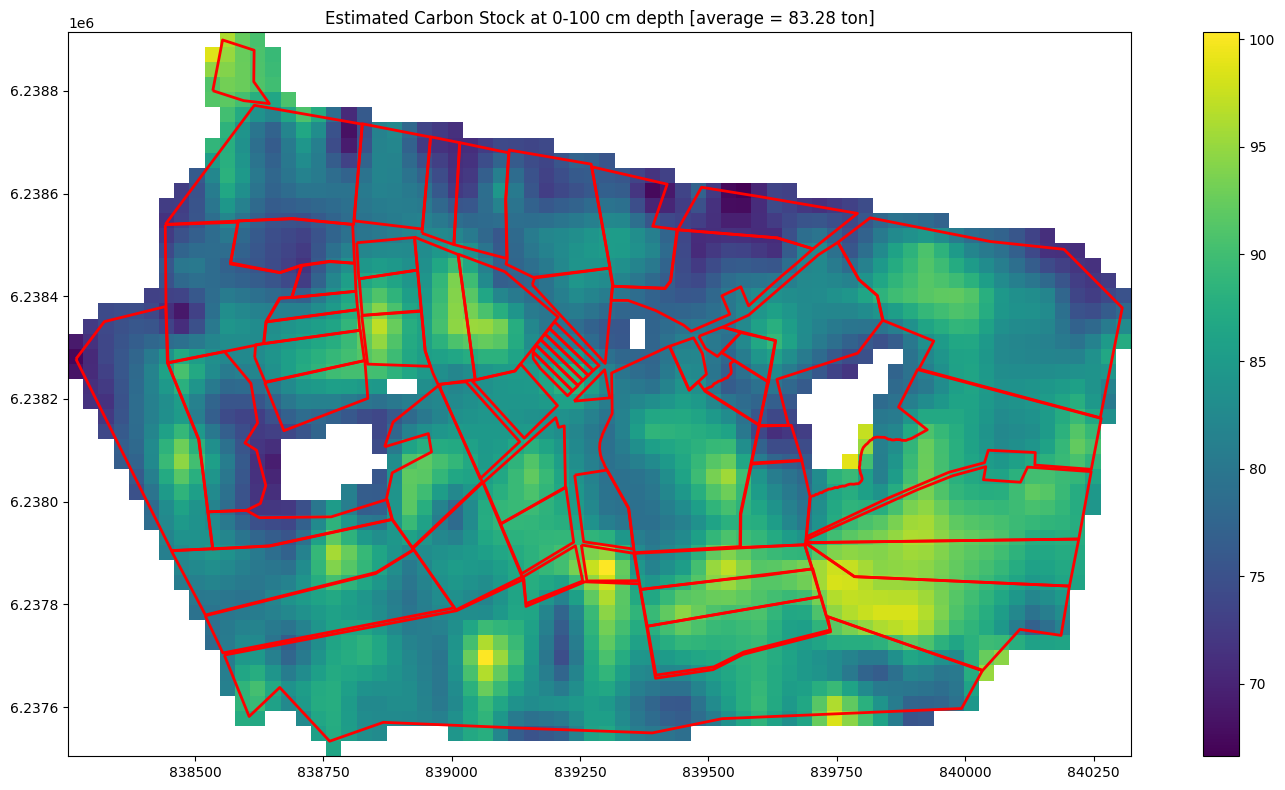

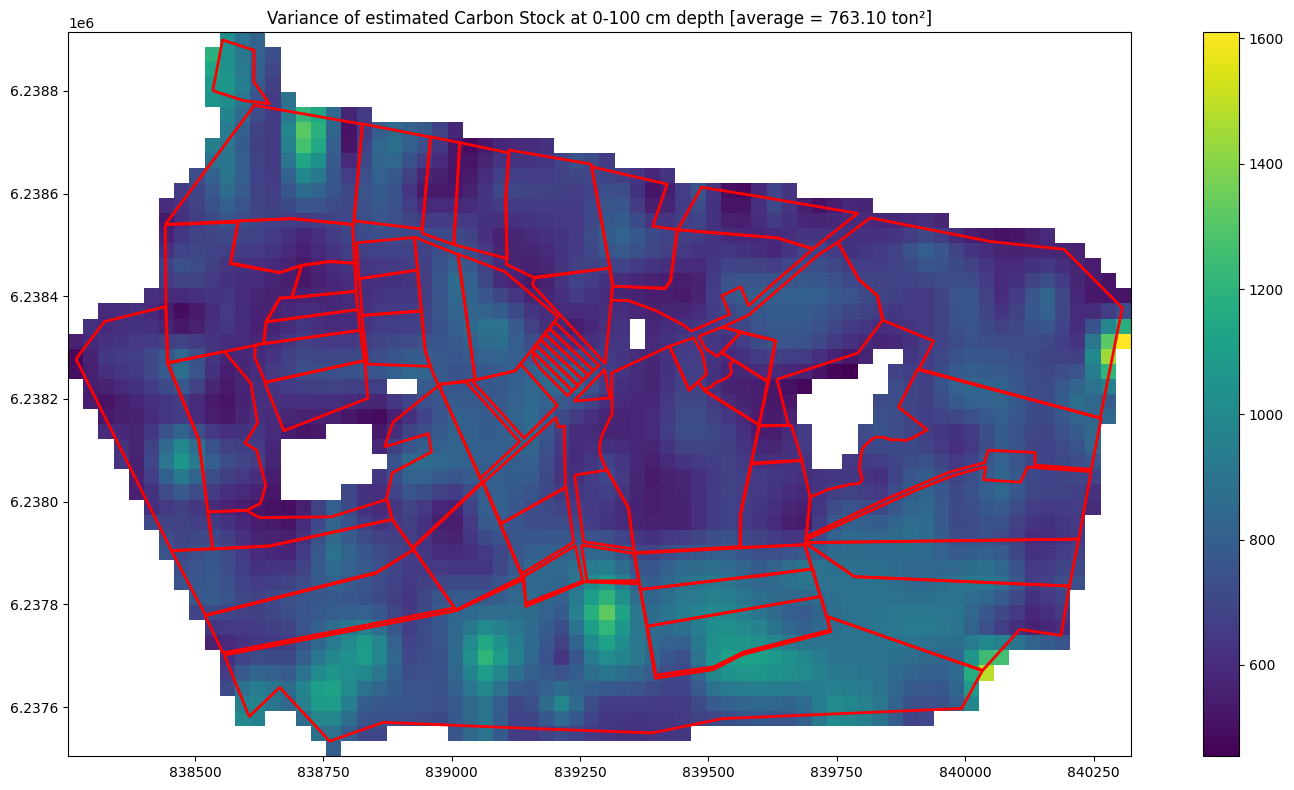

Target sampling variance (ton²): 15.2621


In [3]:
# ---------------------------
# Main workflow
# ---------------------------
gdf_boundary = read_vector_file(VECTOR_PATH)

area_ha = calculate_area_ha(gdf_boundary, dst_crs=DST_CRS)
print(f"Area of Farm (ha): {smart_format(area_ha, fixed_decimals=2)}")

# Clip rasters
clip_raster(meanSOC_in, meanSOC_out, gdf_boundary, crop=crop_to_geom, all_touched=all_touched, buffer_m=buffer_m)
clip_raster(varSOC_in,  varSOC_out,  gdf_boundary, crop=crop_to_geom, all_touched=all_touched, buffer_m=buffer_m)

print("Clipped rasters saved:")
print(" -", meanSOC_out)
print(" -", varSOC_out)

# Extract points (assumes your utils.extract_to_csv writes OUTPUT_DIR / "SOC_points.csv")
utils.extract_to_csv()

dataset = stratify.open_CSV(OUTPUT_DIR / "SOC_points.csv")
mean, var = stratify.overall_mean_variance(dataset)

print(f"Mean estimated Carbon Stock (0–100 cm): {mean:.2f} ton")
print(f"Mean variance of estimated Carbon Stock: {var:.2f} ton²")

# Plot mean + variance rasters (using your existing plotting function)
fig1 = stratify.plot_continuous_data_fig(
    dataset, "Val",
    plot_title=f"Estimated Carbon Stock at 0-100 cm depth [average = {mean:.2f} ton]",
    gdf=gdf_boundary,
    raster_crs=DST_CRS
)
fig2 = stratify.plot_continuous_data_fig(
    dataset, "Var",
    plot_title=f"Variance of estimated Carbon Stock at 0-100 cm depth [average = {var:.2f} ton²]",
    gdf=gdf_boundary,
    raster_crs=DST_CRS
)

plt.show(fig1)
plt.show(fig2)

aimed_Svar = var * aimed_Svar_factor
print(f"Target sampling variance (ton²): {smart_format(aimed_Svar, fixed_decimals=4)}")

smooth iter 1: changed=3.85% | n_strata=3
smooth iter 2: changed=1.02% | n_strata=3
smooth iter 3: changed=0.53% | n_strata=3
after merge (<8%): n_strata=1
smooth iter 1: changed=9.46% | n_strata=3
smooth iter 2: changed=3.67% | n_strata=3
smooth iter 3: changed=2.08% | n_strata=3
after merge (<8%): n_strata=2
smooth iter 1: changed=14.99% | n_strata=4
smooth iter 2: changed=6.45% | n_strata=4
smooth iter 3: changed=3.49% | n_strata=4
after merge (<8%): n_strata=3
smooth iter 1: changed=18.13% | n_strata=6
smooth iter 2: changed=6.98% | n_strata=6
smooth iter 3: changed=3.27% | n_strata=6
after merge (<8%): n_strata=3
smooth iter 1: changed=19.89% | n_strata=6
smooth iter 2: changed=8.22% | n_strata=6
smooth iter 3: changed=4.38% | n_strata=6
after merge (<8%): n_strata=4


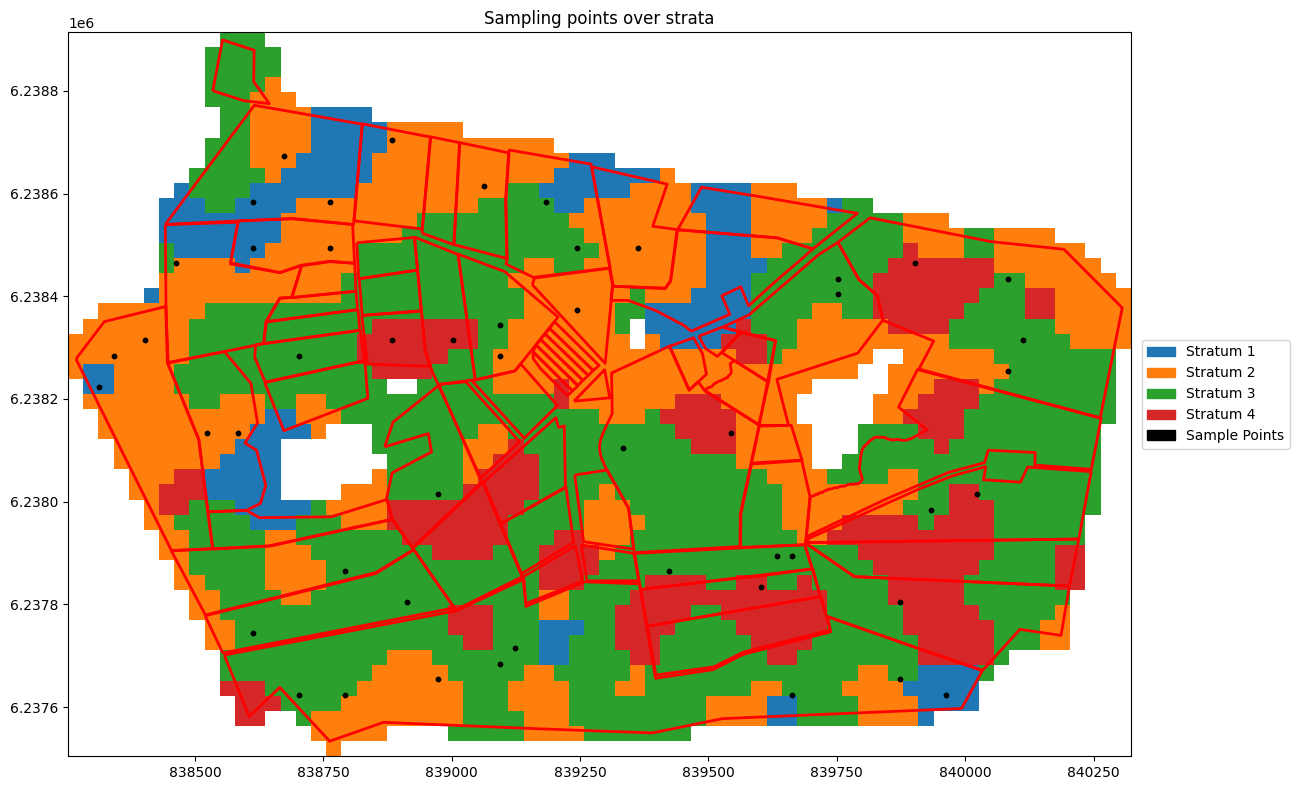


=== Sampling result ===
Strata (H): 4
Total samples: 49
Sampling variance (ton²): 14.9487
Sampling error (ton): 3.8664

Saved outputs:
 - /home/marliana/shared_folder/CarbonApp/output/stratified_dataset_John_Bruce_Pye_Farm-boundaries.csv
 - /home/marliana/shared_folder/CarbonApp/output/sampling_points_John_Bruce_Pye_Farm-boundaries.csv

Note: Coordinates are EPSG:32755 (WGS 84 / UTM zone 55S), units in meters.


In [ ]:


best = stratify.choose_best_by_lowest_svar_across_H(
    dataset,
    H_max=H_max,
    area=area_ha,
    nh_min=nh_min,
    aimed_Svar=aimed_Svar,
    minDistance=minDistance,
    geom_boundary=gdf_boundary.to_crs(DST_CRS),
    edge_buffer=edge_buffer,
)

if best is None:
    raise RuntimeError("No feasible design found. Try lowering minDistance, lowering nh_min, or relaxing aimed_Svar.")

strata_df = best["strata_df"]
samp_df   = best["samp_df"]

# transform X (easting), Y (northing)
samp_df["lon"], samp_df["lat"] = transformer.transform(
    samp_df["X"].to_numpy(),
    samp_df["Y"].to_numpy()
)

strata_df["lon"], strata_df["lat"] = transformer.transform(
    strata_df["X"].to_numpy(),
    strata_df["Y"].to_numpy()
)

fig3 = stratify.plot_stratum_grid_fig(
    strata_df, "strata", samp_df,
    plot_title="Sampling points over strata",
    gdf=gdf_boundary,
    raster_crs=DST_CRS
)
plt.show(fig3)

# Summary
n_strata = best["n_strata"]
n_samples = best["n_samples"]
sampling_variance = best["sampling_variance"]
sampling_error = float(np.sqrt(sampling_variance))

print("\n=== Sampling result ===")
print(f"Strata (H): {n_strata}")
print(f"Total samples: {n_samples}")
print(f"Sampling variance (ton²): {smart_format(sampling_variance, fixed_decimals=4)}")
print(f"Sampling error (ton): {smart_format(sampling_error, fixed_decimals=4)}")

# Save outputs
strata_csv = OUTPUT_DIR / f"stratified_dataset_{VECTOR_PATH.stem}.csv"
samp_csv   = OUTPUT_DIR / f"sampling_points_{VECTOR_PATH.stem}.csv"

strata_df.to_csv(strata_csv, index=False)
samp_df.to_csv(samp_csv, index=False)

print("\nSaved outputs:")
print(" -", strata_csv)
print(" -", samp_csv)
print("\nNote: Coordinates are EPSG:32755 (WGS 84 / UTM zone 55S), units in meters.")


In [ ]:
buffer_m = 15
minDistance = 25
edge_buffer = 15
nh_min = 3
H_max = 7
aimed_Svar_factor = 0.02  # aimed_Svar = var * this
print(aimed_Svar)

In [ ]:
fixed = stratify.choose_global_minimum_samples_by_fixed_H(
    data=dataset,
    defH=6,
    area=area_ha,
    nh_min=nh_min,
    aimed_Svar=aimed_Svar,
    minDistance=minDistance,
    geom_boundary=gdf_boundary.to_crs(DST_CRS),
    edge_buffer=edge_buffer,
)

if fixed is None:
    raise RuntimeError("No feasible design found. Try lowering minDistance, lowering nh_min, or relaxing aimed_Svar.")

strata_df = fixed["strata_df"]
samp_df   = fixed["samp_df"]
 
# transform X (easting), Y (northing)
samp_df["lon"], samp_df["lat"] = transformer.transform(
    samp_df["X"].to_numpy(),
    samp_df["Y"].to_numpy()
)

fig3 = stratify.plot_stratum_grid_fig(
    strata_df, "strata", samp_df,
    plot_title="Sampling points over strata",
    gdf=gdf_boundary,
    raster_crs=DST_CRS
)
plt.show(fig3)

# Summary
n_strata = fixed["n_strata"]
n_samples = fixed["n_samples"]
sampling_variance = fixed["sampling_variance"]
sampling_error = float(np.sqrt(sampling_variance))
print("\n=== Sampling result (fixed H) ===")
print(f"Strata (H): {n_strata}")
print(f"Total samples: {n_samples}")
print(f"Sampling variance (ton²): {smart_format(sampling_variance, fixed_decimals=4)}")
print(f"Sampling error (ton): {smart_format(sampling_error, fixed_decimals=4)}")


In [ ]:
# Save outputs
strata_csv = OUTPUT_DIR / "stratified_dataset.csv"
samp_csv   = OUTPUT_DIR / "sampling_points.csv"

strata_df.to_csv(strata_csv, index=False)
samp_df.to_csv(samp_csv, index=False)

print("\nSaved outputs:")
print(" -", strata_csv)
print(" -", samp_csv)
print("\nNote: Coordinates are EPSG:32755 (WGS 84 / UTM zone 55S), units in meters.")
